In [1]:
# builtin deps
import os
import typing as t
from pathlib import Path
from collections import defaultdict

# third parties deps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

# Load data from clean database (clean_datasets_dir)

In [2]:
CLEAN_DATASETS_DIR = Path("./clean_datasets")

In [3]:
hourly_dfs = defaultdict(lambda : pd.DataFrame())

for path in CLEAN_DATASETS_DIR.iterdir():
    file_name_wo_ext = path.name.split('.')[0]
    hourly_dfs[file_name_wo_ext] = pd.read_csv(path, index_col=0)
    # convert index to timestamp for further implementation
    hourly_dfs[file_name_wo_ext].index = pd.to_datetime(hourly_dfs[file_name_wo_ext].index)

# add total_people in dataframe
hourly_dfs['people']['total_people'] = \
    hourly_dfs['people']['zone1']\
    + hourly_dfs['people']['zone2']\
    + hourly_dfs['people']['zone3']\
    + hourly_dfs['people']['zone4']

## Check number of entry for hourly data

In [4]:
for name in hourly_dfs:
    print(f"{name}\n", "number of entries:", len(hourly_dfs[name]), end="\n\n")

meter1_phase1
 number of entries: 610

people
 number of entries: 152

weather
 number of entries: 986

meter2_phase1
 number of entries: 610



## Check completeness of the time series data

In [5]:
def check_completeness(dfs):
    
    for name in dfs:
        
        # calculate number of hours in the time series interval
        time_delta = dfs[name].index[-1] - dfs[name].index[0]
        expected_hours = time_delta.days*24 + time_delta.seconds//3600 + 1
        
        print(name, f"--> completness {len(dfs[name])/expected_hours*100:.0f}%")
        print(f"expected num hours: {expected_hours:,d} number of entries: {len(dfs[name]):,d}", end="\n\n")

In [6]:
check_completeness(hourly_dfs)

meter1_phase1 --> completness 99%
expected num hours: 618 number of entries: 610

people --> completness 16%
expected num hours: 935 number of entries: 152

weather --> completness 100%
expected num hours: 986 number of entries: 986

meter2_phase1 --> completness 99%
expected num hours: 618 number of entries: 610



*The completeness of the people dataset is too low*

## Combine meter1 and meter 2 data with inner join

In [7]:
hourly_dfs['total_meter'] = hourly_dfs['meter2_phase1']\
    .join(hourly_dfs['meter1_phase1'], lsuffix='_meter2', rsuffix='_meter1', how='inner')

In [8]:
# calculate total power of this hotel
hourly_dfs['total_meter']['total_power'] = \
    hourly_dfs['total_meter']['power_meter1'] \
    + hourly_dfs['total_meter']['power_meter2']

## Combine total_meter and weather data using inner join

In [9]:
hourly_dfs['meters_weather'] = hourly_dfs['total_meter'].join(hourly_dfs['weather'], how='inner')

## Combine total_meter and people data using inner join

In [10]:
hourly_dfs['meters_people'] = hourly_dfs['total_meter'].join(hourly_dfs['people'], how='inner')

## Combine total_meter, weather, people data using inner join

In [11]:
hourly_dfs['mwp'] = hourly_dfs['meters_weather'].join(hourly_dfs['people'], how='inner')

# Visualization

## Visualize electricity consumption vs temperature

<AxesSubplot:>

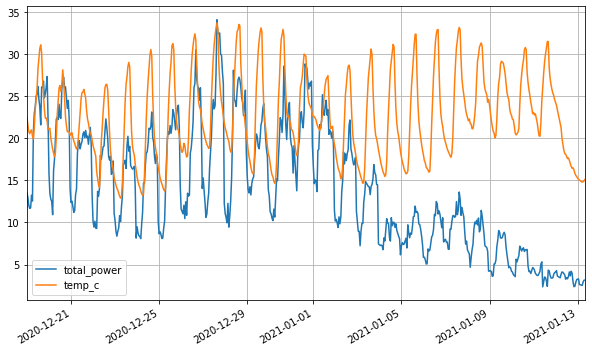

In [12]:
hourly_dfs['meters_weather'].plot(y=['total_power', 'temp_c'], grid=True, figsize=(10, 6))

In [13]:
hourly_dfs['meters_weather'].corr()

,power_meter2,power_meter1,total_power,temp_c
power_meter2,1.000000,0.858695,0.990364,0.329461
power_meter1,0.858695,1.000000,0.921395,0.428307
total_power,0.990364,0.921395,1.000000,0.365578
temp_c,0.329461,0.428307,0.365578,1.000000


We can see the abruptly changing in energy consumption behavior since 3 Jan 2021,  
because the long holiday is end at that day and because of the spread of Covid 19.

## Visualize electricity consumption vs temperature before abruptly changing

In [14]:
before_abt_ind = hourly_dfs['meters_weather'].index < pd.to_datetime('2021-01-03')

<AxesSubplot:>

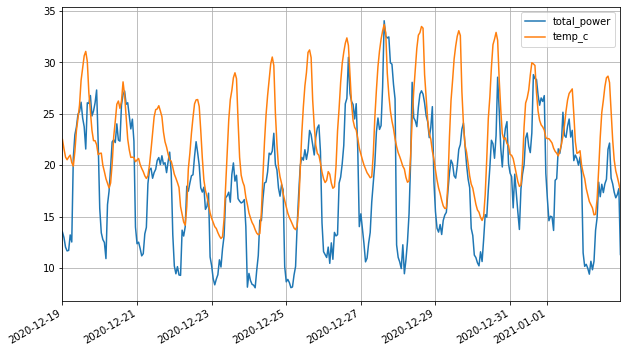

In [15]:
hourly_dfs['meters_weather'][before_abt_ind]\
.plot(y=['total_power', 'temp_c'], grid=True, figsize=(10, 6))

In [16]:
hourly_dfs['meters_weather'][before_abt_ind].corr()

,power_meter2,power_meter1,total_power,temp_c
power_meter2,1.000000,0.799535,0.981913,0.736396
power_meter1,0.799535,1.000000,0.898790,0.700687
total_power,0.981913,0.898790,1.000000,0.758355
temp_c,0.736396,0.700687,0.758355,1.000000


<AxesSubplot:xlabel='total_power', ylabel='temp_c'>

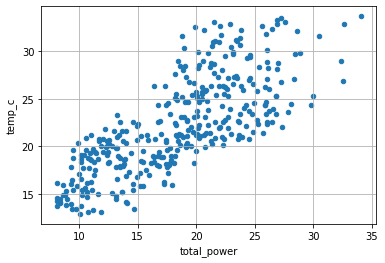

In [17]:
hourly_dfs['meters_weather'][before_abt_ind].plot.scatter(x='total_power', y='temp_c', grid=True)

**The temperature and total electricity power is strongly related!**

## Visualize electricity consumption vs number of people

<AxesSubplot:>

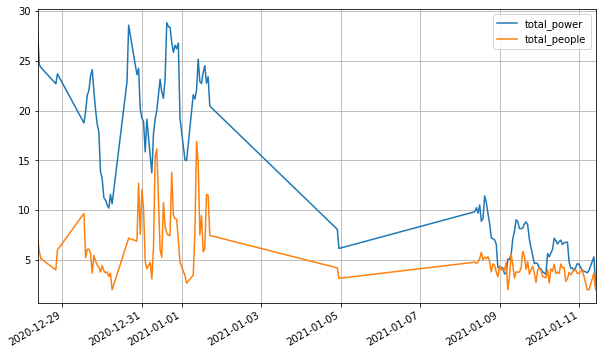

In [18]:
hourly_dfs['meters_people'].plot(y=['total_power', 'total_people'], grid=True, figsize=(10, 6))

In [19]:
hourly_dfs['meters_people'].corr()

,power_meter2,power_meter1,total_power,zone1,zone2,zone3,zone4,total_people
power_meter2,1.000000,0.891182,0.992140,0.224154,0.480398,0.317597,0.582995,0.628779
power_meter1,0.891182,1.000000,0.940942,0.197897,0.456837,0.347680,0.650266,0.640696
total_power,0.992140,0.940942,1.000000,0.221878,0.484543,0.332931,0.614467,0.645997
zone1,0.224154,0.197897,0.221878,1.000000,0.261046,0.163719,-0.035167,0.679217
zone2,0.480398,0.456837,0.484543,0.261046,1.000000,0.177936,0.285192,0.683271
zone3,0.317597,0.347680,0.332931,0.163719,0.177936,1.000000,0.421200,0.420922
zone4,0.582995,0.650266,0.614467,-0.035167,0.285192,0.421200,1.000000,0.623889
total_people,0.628779,0.640696,0.645997,0.679217,0.683271,0.420922,0.623889,1.000000


In [20]:
hourly_dfs['meters_people'][['total_power', 'total_people']].corr()

,total_power,total_people
total_power,1.000000,0.645997
total_people,0.645997,1.000000


<AxesSubplot:xlabel='total_power', ylabel='total_people'>

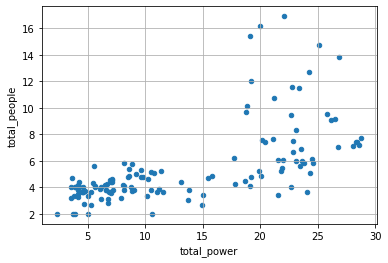

In [21]:
hourly_dfs['meters_people'].plot.scatter(x='total_power', y='total_people', grid=True)

**The number of people in the hotel and total electricity power is quite related**